In [1]:
# !pip3 install numpy
# !pip3 install xgboost
# !pip3 install sklearn
# !pip3 install joblib
# !pip3 install pandas
# !pip3 install recsim_ng

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

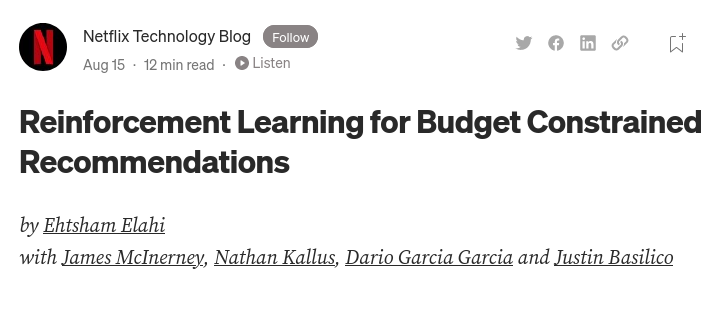

* For post, see: [link](https://netflixtechblog.com/reinforcement-learning-for-budget-constrained-recommendations-6cbc5263a32a)
* Below code is mostly copy-pasted from the above

# Notes

* Budgeted slate recommendation:
  * Given a set of $N$ items, an agent must rank the $K$ most relevant ones to form a slate. (See also [SlateQ](https://medium.com/analytics-vidhya/slateq-a-scalable-algorithm-for-slate-recommendation-problems-735a1c24458c), [Off-policy evaluation for slate recommendation](https://proceedings.neurips.cc/paper/2017/file/5352696a9ca3397beb79f116f3a33991-Paper.pdf)).
  * Item $x_i\in\mathcal{X}$ has relevance $\sigma_{x_i}$ and incurs cost $c_{x_i}$ 
  * Get user to pick one an item from the slate given budget $u$
* [edward](https://github.com/google/edward2) / [recsim_ng](https://github.com/google-research/recsim_ng) main frameworks used

In [3]:
import edward2 as ed
from recsim_ng.entities.recommendation import corpus
from recsim_ng.core.value import Value

class RelevanceAndCostCorpus(corpus.Corpus):
    def __init__(self,
                 config,
                 doc_costs,
                 doc_relevances,
                 name = "RelevanceAndCostCorpus"):
        super().__init__(config, name)
        self.doc_costs = ed.Deterministic(doc_costs.astype(np.float32))
        self.doc_relevances = ed.Deterministic(doc_relevances.astype(np.float32))

    def specs(self):
        state_spec = ValueSpec(relevances = FieldSpec(),
                               costs = FieldSpec())
        return state_spec.prefixed_with('state').union(
            state_spec.prefixed_with("available_docs"))

    def initial_state(self):
        return Value(relevances = self.doc_relevances, costs = self.doc_costs)

    def next_state(self, previous_state):
        return previous_state.map(ed.Deterministic)

    def available_documents(self, corpus_state):
        """The available_documents value."""
        return corpus_state.map(ed.Deterministic)

* Example corpus: \
    $\mathcal{X}=\lbrace x_1, x_2 \rbrace$, where e.g. item $x_1$ has relevance $\sigma_{x_1}=0.5$ and cost $c_{x_1}=0.2$

In [5]:
import numpy as np

X = [
    {
        'relevance': 0.5,
        'cost': 0.2
    },
    {
        'relevance': 0.3,
        'cost': 0.1
    }
]
N = len(X)

corpus = RelevanceAndCostCorpus(
    config={
        'num_docs': N,           # Total number of items N
        'num_topics': len(X[0])  # Number of features for an item
    },
    doc_costs=np.array([x['cost'] for x in X]),
    doc_relevances=np.array([x['relevance'] for x in X])
)

For certain models a "ground truth" is defined

In [6]:
import functools

def define_ground_truth(cls, **kwargs):
    return functools.partial(cls, **kwargs)

In [7]:
def run(
    doc_costs = None,
    doc_relevances = None
):
    gt_corpus_ctor = define_ground_truth(
        cls=RelevanceAndCostCorpus,
        doc_costs=doc_costs,
        doc_relevances=doc_relevances
    )